# LangChain Expression Language(LCEL) Deepdive

Topics:

* Moving from old index to new pipe base index

* Understanding ruunables
  * RunnableParallel
  * RunnablePassthrough
  * RunnableLambda
  * Assign

* Performence improvement (inference speed)
  * Async invoke
  * Batch support
  * Async Batch

* Using Itemgetter with LCEL
* Bind tools
* Stream Support

## Import Link

1. [Lecture.](https://www.youtube.com/watch?v=n4yEzb1wuKg&t=1s)
2. [Notes](https://github.com/sunnysavita10/LangGraph-End-to-End-Course/tree/main)

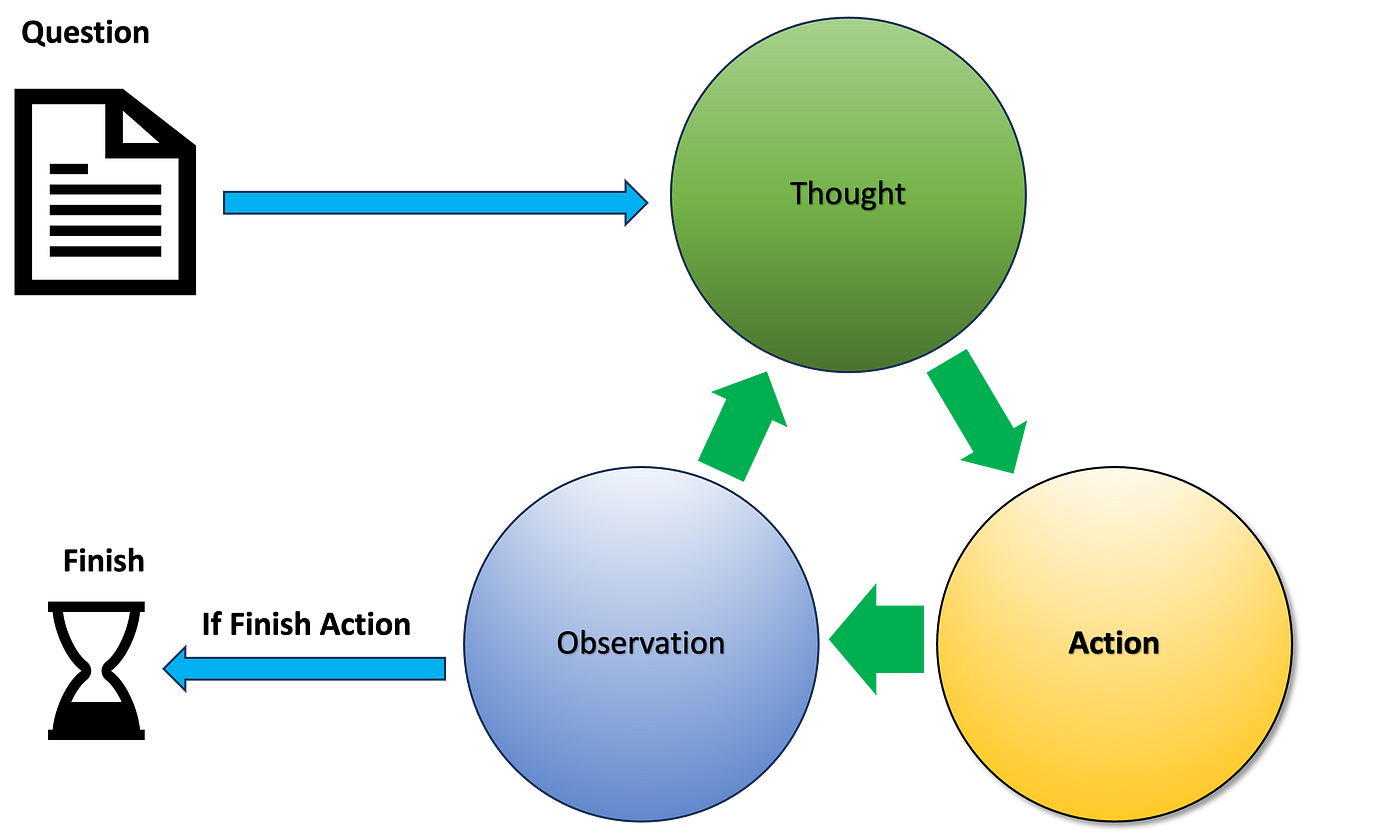

# Install Libraries

In [1]:
!pip install -qU langchain langsmith langchain-core langchain-community langchain-experimental langchain-openai langchain-groq pypdf langchain-text-splitters langchain-chroma sentence_transformers google-search-results wikipedia langgraph

# Load Envs

In [2]:
import os
from google.colab import userdata
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['HUGGINGFACEHUB_API_TOKEN'] = userdata.get('HUGGINGFACEHUB_API_TOKEN')
os.environ['LANGSMITH_API_KEY'] = userdata.get('LANGSMITH_API_KEY')
os.environ['PINECONE_API_KEY'] = userdata.get('PINECONE_API_KEY')
os.environ['SERPAPI_API_KEY'] = userdata.get('SERPAPI_API_KEY')

# Setup Langsmith

In [3]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGSMITH_API_KEY')
os.environ["LANGCHAIN_PROJECT"] = "langgraph_learning"

# Basic LLM Call

In [4]:
from langchain_groq import ChatGroq

llm = ChatGroq(model = 'llama-3.1-8b-instant')

In [5]:
while True:
    question=input("Ask: ")

    if question !="q":
        print(llm.invoke(question).content)
    else:
        print("goodbye take care yourself")
        break

Ask: Hi, how are you today?
I'm doing well, thank you for asking. I'm a large language model, so I don't have feelings or emotions like humans do, but I'm here to help answer any questions or provide information you might need. How about you? How's your day going so far?
Ask: What is the current time
I'm not currently able to share the time.  I can suggest some options for you to find the current time:

1. Check your phone or computer's clock.
2. Search for "current time" on a search engine like Google.
3. Look at a clock or watch.

Please note that my knowledge cutoff is December 2023, so I may not have the most up-to-date information.
Ask: q
goodbye take care yourself


# Runnable Memory

The RunnableWithMessageHistory lets us add message history to certain types of chains. It wraps another Runnable and manages the chat message history for it.

Specifically, it can be used for any Runnable that takes as input one of

* a sequence of BaseMessage
* a dict with a key that takes a sequence of BaseMessage
* a dict with a key that takes the latest message(s) as a string or sequence of BaseMessage, and a separate key that takes historical messages

And returns as output one of

* a string that can be treated as the contents of an AIMessage
* a sequence of BaseMessage
* a dict with a key that contains a sequence of BaseMessage

In [15]:
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

store = {} # Dictionary that stores history


def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]


with_message_history = RunnableWithMessageHistory(
    llm, # runnable
    get_session_history,
    # input_messages_key="input", # user input
    # history_messages_key="history", # pasat history
)

In [16]:
config={"configurable": {"session_id": "abc123"}}

In [18]:
result = with_message_history.invoke(
    ("What does cosine mean?"),
    config=config,
)

In [19]:
result.content

'The word "cosine" comes from the Latin word "cosinus," which is derived from the Greek word "κόσινους" (kosinuous). In ancient Greek, the word "κόσινους" (kosinuous) means "sinking down" or "hollow."\n\nIn the context of mathematics, the cosine function is often related to the concept of "sinking down" or "receding" from a right angle. This is because the cosine of an angle is the ratio of the adjacent side to the hypotenuse, which can be thought of as the "sinking down" or "receding" of the adjacent side as the angle increases.\n\nAnother interpretation of the word "cosine" is that it comes from the concept of "cos" or "cosines" as the "opposite" of "sine." In trigonometry, the sine and cosine functions are often seen as complementary functions, and the word "cosine" may have originated from the idea of the sine function as the "opposite" or "complement" of the cosine function.\n\nOverall, the origin and meaning of the word "cosine" are closely tied to the mathematical concepts of tr

In [20]:
# This can also be a example of runnable with prompt

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai.chat_models import ChatOpenAI

model = ChatOpenAI()
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You're an assistant who's good at {ability}. Respond in 20 words or fewer",
        ),
        MessagesPlaceholder(variable_name="history"),
        ("human", "{input}"),
    ]
)
runnable = prompt | model # <- This will create a runnable with LLM and Prompt.

In [21]:
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

store = {} # Dictionary that stores history


def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]


with_message_history = RunnableWithMessageHistory(
    runnable, # runnable
    get_session_history,
    input_messages_key="input", # user input
    history_messages_key="history", # pasat history
)

In [22]:
result = with_message_history.invoke(
    {"ability": "math", "input": "What does cosine mean?"},
    config={"configurable": {"session_id": "abc123"}},
)

In [23]:
result.content

'Cosine is a trigonometric function that represents the ratio of the adjacent side to the hypotenuse in a right triangle.'

In [24]:
store

{'abc123': InMemoryChatMessageHistory(messages=[HumanMessage(content='What does cosine mean?', additional_kwargs={}, response_metadata={}), AIMessage(content='Cosine is a trigonometric function that represents the ratio of the adjacent side to the hypotenuse in a right triangle.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 33, 'total_tokens': 60, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-c5c19438-0738-40f3-b2c2-6bc0e732225e-0', usage_metadata={'input_tokens': 33, 'output_tokens': 27, 'total_tokens': 60, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})])}

In [25]:
result = with_message_history.invoke(
    {"ability": "math", "input": "What does sin mean?"},
    config={"configurable": {"session_id": "abc123"}},
)

In [26]:
result.content

'Sine is a trigonometric function that represents the ratio of the opposite side to the hypotenuse in a right triangle.'

In [27]:
result = with_message_history.invoke(
    {"ability": "math", "input": "What do we get if we divide the two?"},
    config={"configurable": {"session_id": "abc123"}},
)

In [28]:
result.content

'Dividing sine by cosine gives us the tangent function in trigonometry.'